In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
raw_data = pd.read_csv("flats.csv")

In [3]:
raw_data.head(10)

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0
5,8410,5950000,43,27.0,2.0,5.0
6,8423,5900000,46,29.0,2.0,5.0
7,8427,2000000,45,29.0,2.0,6.0
8,8452,4500000,38,24.0,2.0,5.0
9,8470,4569600,54,32.0,2.0,9.0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6042 non-null   int64  
 1   price_doc   6042 non-null   int64  
 2   full_sq     6042 non-null   int64  
 3   life_sq     6042 non-null   float64
 4   num_room    6042 non-null   float64
 5   kitch_sq    6042 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 283.3 KB


In [5]:
# Пробежимся по количеству встречающихся значений по всем признакам
raw_data.nunique().sort_values()

num_room        11
kitch_sq        41
life_sq        131
full_sq        163
price_doc     1071
Unnamed: 0    6042
dtype: int64

In [6]:
raw_data.describe()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6042.000000,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,19846.990070,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6081.011373,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,8056.000000,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,14573.250000,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,19871.500000,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,25147.750000,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,30470.000000,9.512250e+07,637.000000,637.000000,17.000000,96.000000


In [7]:
raw_data = raw_data.reindex(columns=['price_doc','Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq'])

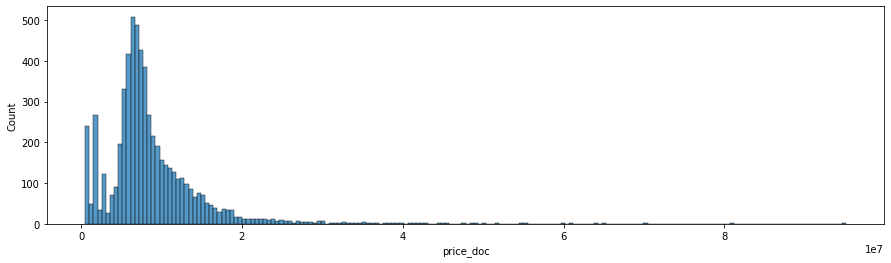

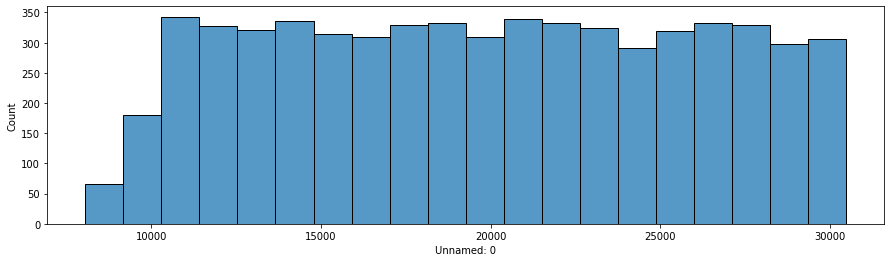

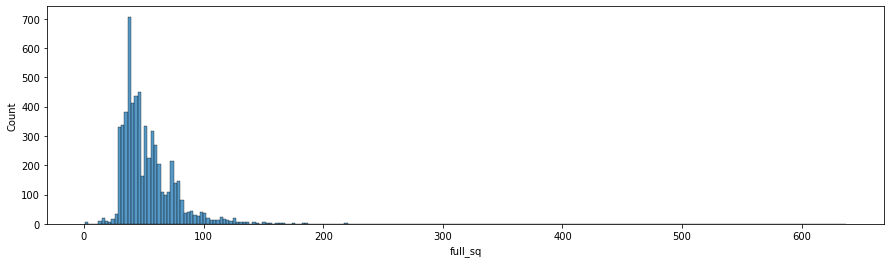

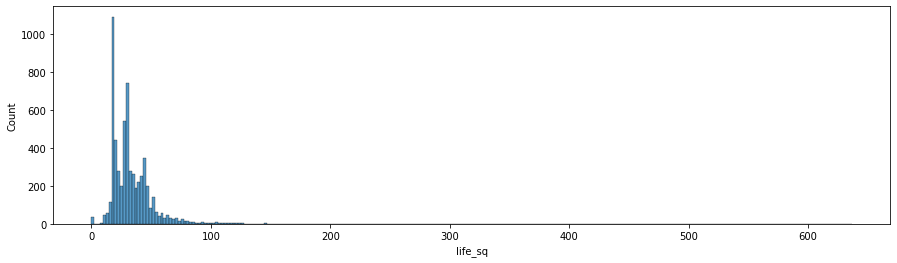

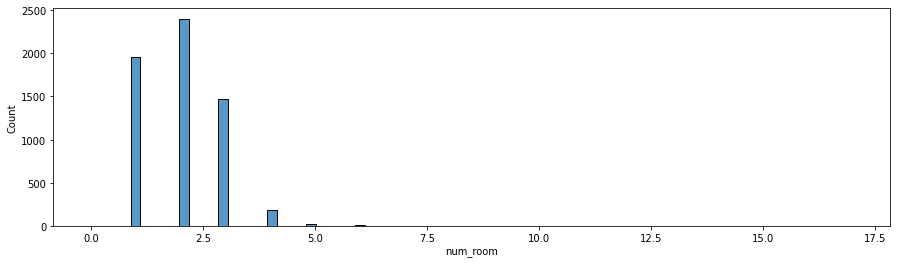

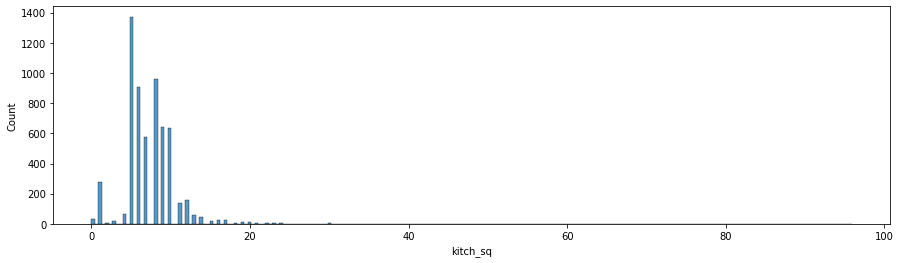

In [8]:
for c in raw_data.columns:

    fig, axes = plt.subplots(1, 1, figsize=(15, 4))
    sns.histplot(raw_data[c], kde=False, ax=axes)
    

### Построим boxplot’ы для всех переменных:

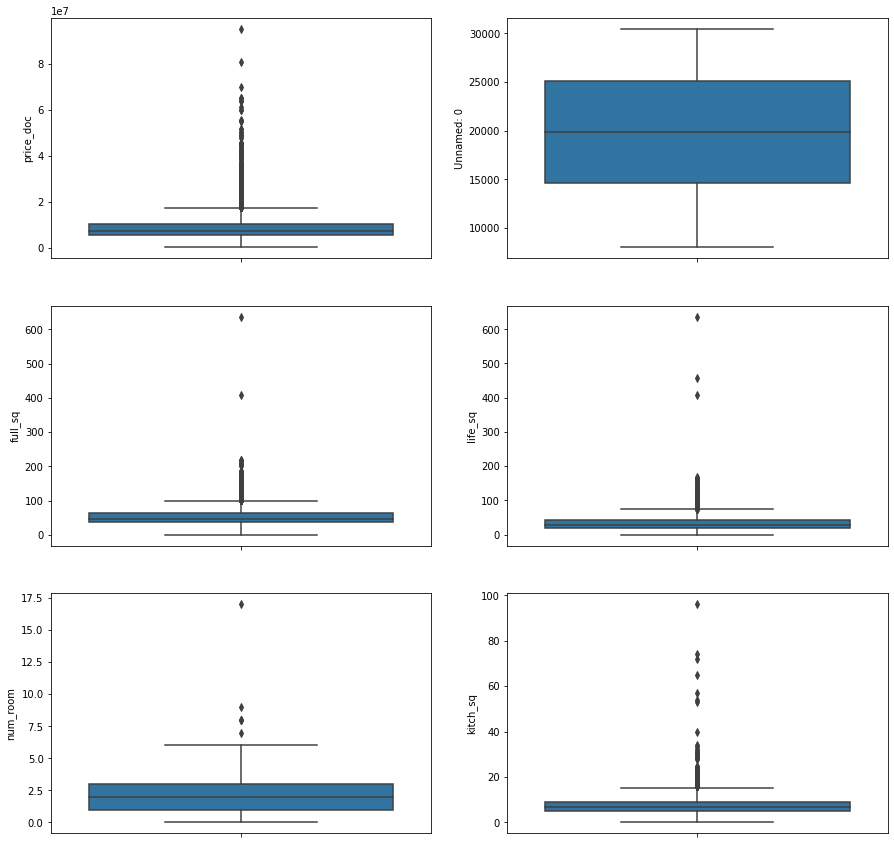

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for col, i in zip(raw_data.columns, range(len(raw_data.columns))):
    sns.boxplot( y=col, data=raw_data, ax=axes.flat[i])

#### Требуется нормализация распределений 

### Проведем нормализацию распределений целевой переменной и признаков.

In [1]:
# %% [code]
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.

    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

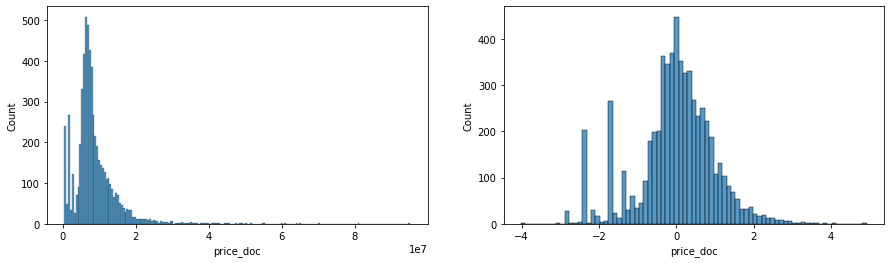

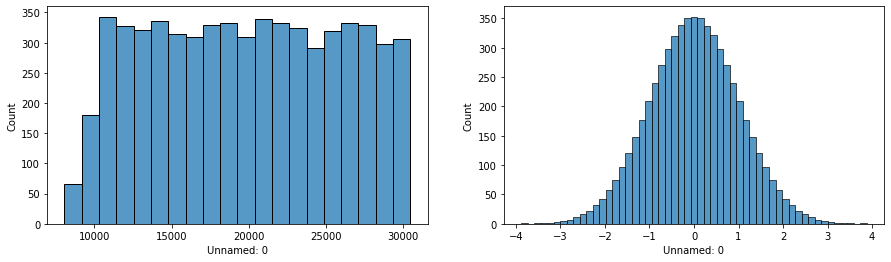

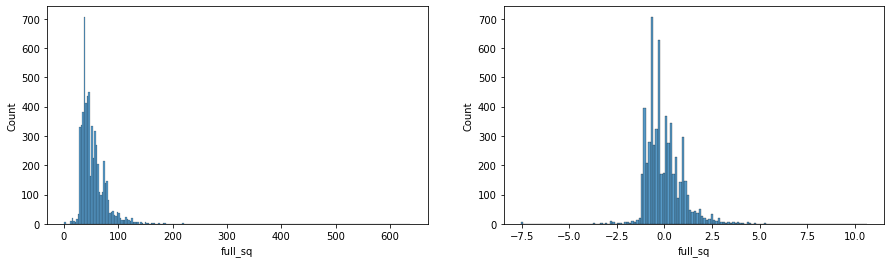

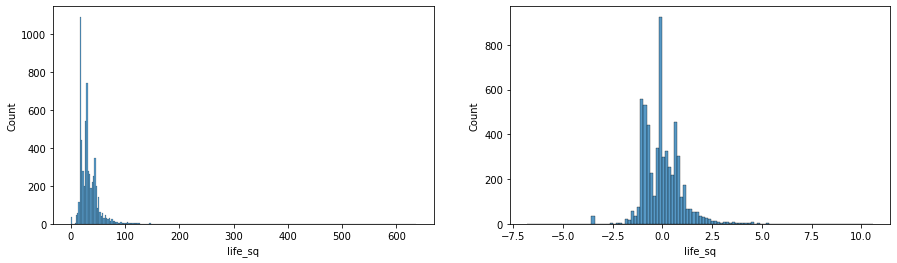

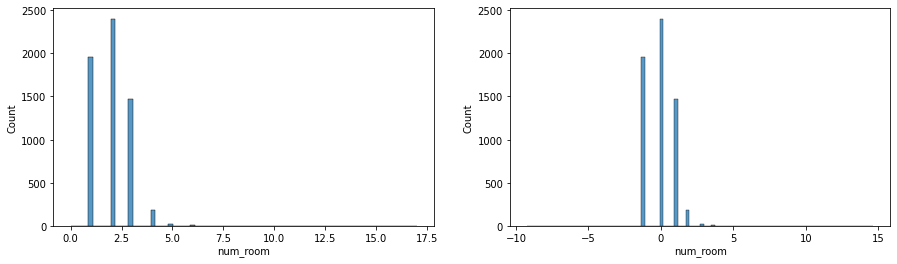

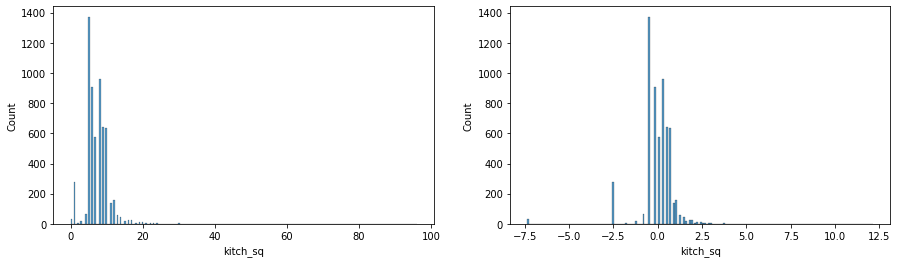

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from gauss_rank_scaler import GaussRankScaler
def data_transform(data,col,transform_): # вспомогательная функция для препроцессинга данных
 
    # data - numpy array
    # transform_ = -1 - bypass
    # transform_ = 0 - StandardScaler
    # transform_ = 1 - Log 
    # transform_ = 2 - GaussRank 
    # transform_ = 3 - Log & StandardScaler
    # transform_ = 4 - GaussRank & StandardScaler
    if transform_ == -1:
        return data
    elif transform_ == 0:
        return std_sc[col].fit_transform(data.reshape(-1,1)).reshape(-1)
    elif transform_ == 1:
        return np.log1p(data).reshape(-1)
    elif transform_ == 2:
        return gr_sc[col].fit_transform(data.reshape(-1,1)).reshape(-1)
    elif transform_ == 3:
        return std_sc[col].fit_transform(np.log1p(data).reshape(-1,1)).reshape(-1)
    elif transform_ == 4:
        return std_sc[col].fit_transform(gr_sc[col].fit_transform(data.reshape(-1,1))).reshape(-1)

    else:
        print('!!! transform_ is in [-1,4]')
    

def data_inv_transform(data,col,transform_): # для восстановления первоначального распределения
    if transform_ == -1:
        return data
    elif transform_ == 0:
        return std_sc[col].inverse_transform(data.reshape(-1,1)).reshape(-1)
    elif transform_ == 1:
        return np.expm1(data).reshape(-1)
    elif transform_ == 2:
        return gr_sc[col].inverse_transform(data.reshape(-1,1)).reshape(-1)
    elif transform_ == 3:
        return np.expm1(std_sc[col].inverse_transform(data.reshape(-1,1))).reshape(-1)
    elif transform_ == 4:
        return gr_sc[col].inverse_transform(std_sc[col].inverse_transform(data.reshape(-1,1))).reshape(-1)   
    else:
        print('!!! transform_ is in [-1,4]')
    return (np.exp(data) - 1)
cols2sc = raw_data.columns

df = raw_data.copy()
std_sc = {}
gr_sc = {}
transform = 4


for c in df.columns:
    std_sc[c] = StandardScaler()
    gr_sc[c] = GaussRankScaler(interp_kind='nearest')
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    sns.histplot(raw_data[c], kde=False, ax=axes.flat[0])
    df[c] = data_transform(df[c].values,c,transform)

    sns.histplot(df[c], kde=False, ax=axes.flat[1])

#     df[c] = data_inv_transform(df[c].values,c,transform)
#     sns.histplot(df[c], kde=False, ax=axes.flat[2])
    

#### Вместо логарифмического преобразования я остановился на преобразовании с помощью GаussRankScaler() с последующей нормировкой с помощью StandardScaler(). 
#### В итоге получились довольно неплохие нормальные распределения улучшающие сходимость моделей

### Посмотрим на корреляции

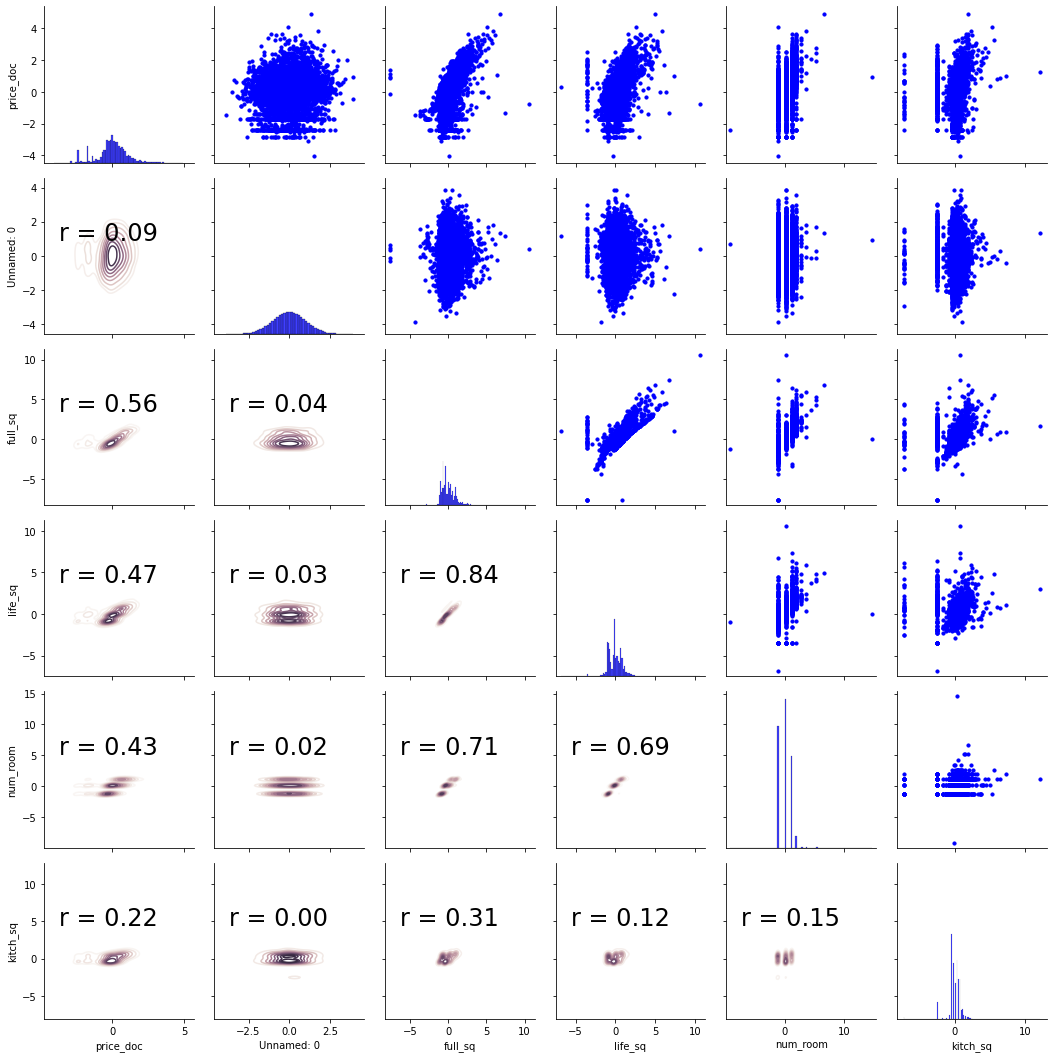

In [11]:
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'blue')

# Distribution on the diagonal
g.map_diag(sns.histplot, kde=False, color = 'blue')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

### Значимость признаков

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

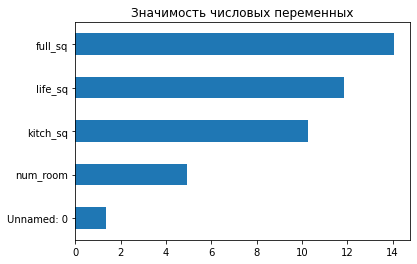

In [12]:
from sklearn.feature_selection import f_classif
imp_num = pd.Series(f_classif(df[['Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq']], df['price_doc'])[
                    0], index=['Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq'])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых переменных')

### Так как корреляция между  целевой переменной и непонятным 'Unamed:0' практически отсутствует (0.09) и значимость у него самая низкая, то предлагаю исключить этот признак из датасета.


In [13]:
df = df[['price_doc','full_sq', 'life_sq','num_room', 'kitch_sq']]

### Построим модель байесовской линейной регрессии

/opt/conda/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


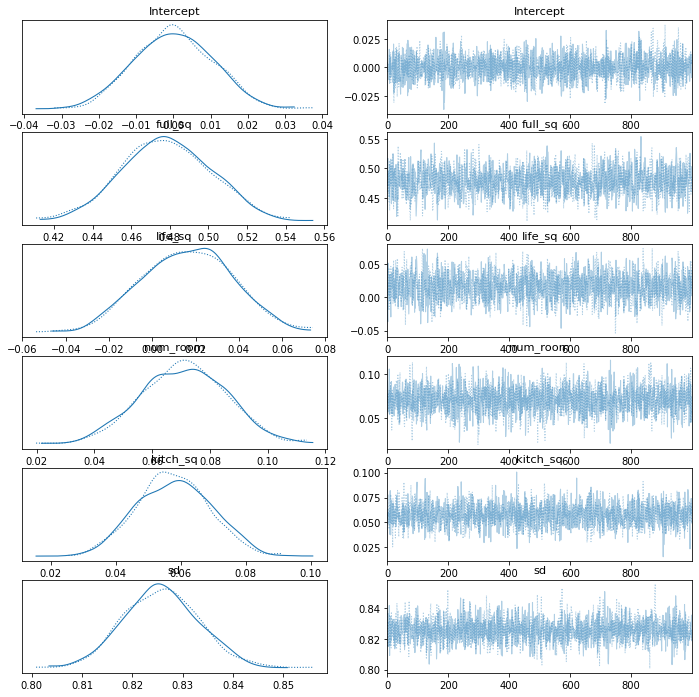

In [14]:


with pm.Model() as linear_model:
    pm.glm.GLM.from_formula('price_doc ~ full_sq + life_sq + num_room + kitch_sq ', df) 
    trace = pm.sample(1000)
    
az.plot_trace(trace);

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


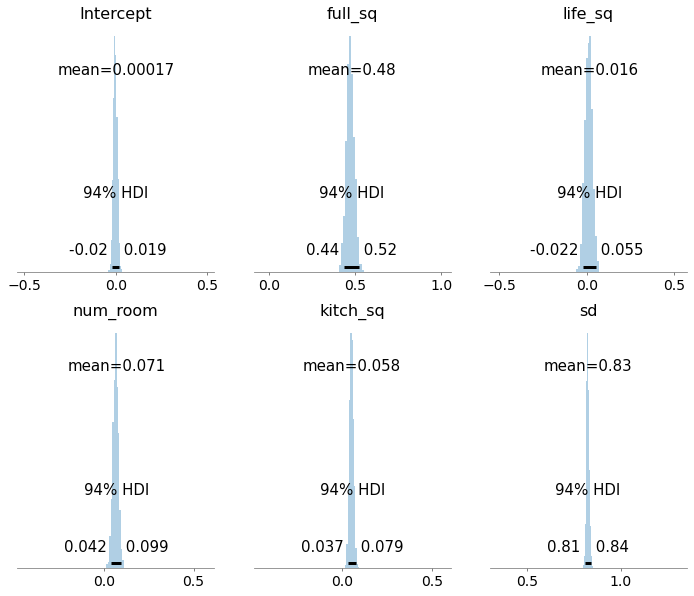

In [15]:
pm.plot_posterior(trace, figsize = (12, 10), kind="hist");

In [16]:
bayes_summary = pm.summary(trace).round(2)

In [17]:
bayes_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.00,0.01,-0.02,0.02,0.0,0.0,3182.0,1246.0,1.0
full_sq,0.48,0.02,0.44,0.52,0.0,0.0,1579.0,1437.0,1.0
life_sq,0.02,0.02,-0.02,0.06,0.0,0.0,1805.0,1518.0,1.0
num_room,0.07,0.02,0.04,0.10,0.0,0.0,2479.0,1416.0,1.0
kitch_sq,0.06,0.01,0.04,0.08,0.0,0.0,2095.0,1430.0,1.0
sd,0.83,0.01,0.81,0.84,0.0,0.0,2450.0,1485.0,1.0


## Сравнение с логистической регрессией

In [18]:
lr = LinearRegression()
lr.fit(df.drop(columns='price_doc'), df['price_doc'])

ols_formula = 'price_doc = %0.2f * %s +' % (lr.intercept_,'Intercept')
for i, col in enumerate(df.drop(columns='price_doc').columns):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'price_doc = -0.00 * Intercept + 0.48 * full_sq + 0.02 * life_sq + 0.07 * num_room + 0.06 * kitch_sq'

In [19]:
model_formula = 'price_doc = '
for variable in trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'price_doc =  0.00 * Intercept + 0.48 * full_sq + 0.02 * life_sq + 0.07 * num_room + 0.06 * kitch_sq + -0.19 * sd_log__ + 0.83 * sd'

### Сравним коэффициенты 

In [20]:
compare_coeffs = pd.DataFrame(bayes_summary['mean'].drop(['sd']))
compare_coeffs['lr_coef'] = [lr.intercept_]+list(lr.coef_)
compare_coeffs['lr_coef'] = compare_coeffs['lr_coef'].round(2)
compare_coeffs.columns = ['bayes_means','LR_coeffs']
compare_coeffs

,bayes_means,LR_coeffs
Intercept,0.00,-0.00
full_sq,0.48,0.48
life_sq,0.02,0.02
num_room,0.07,0.07
kitch_sq,0.06,0.06



## Отлично. Коэффициенты линейной регрессии и байесовской линейной регрессии совпали.

#### Bonus.
#### Посмотрим на эффект влияния каждого коэффициента регрессии и неопределенность в оценках модели

/opt/conda/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


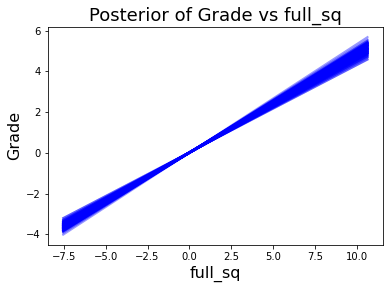

/opt/conda/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


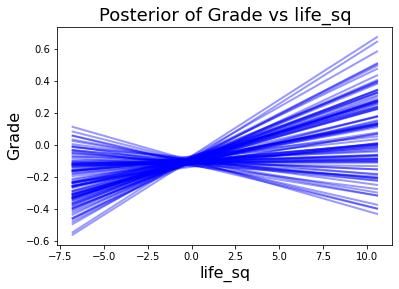

/opt/conda/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


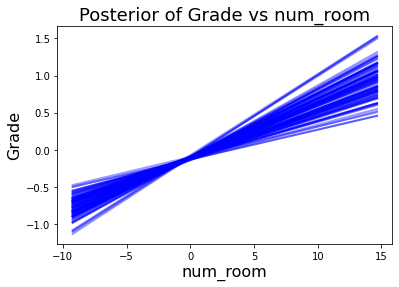

/opt/conda/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


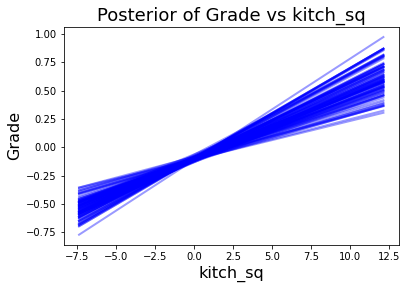

In [21]:
def model_effect( trace, X):

    def lm(value, sample):

        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value

        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:

            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()

        return prediction
   
    for query_var in X.columns:
        # Variables that do not change
        steady_vars = list(X.columns)
        steady_vars.remove(query_var)
        
        # Find the minimum and maximum values for the range of the query var
        var_min = X[query_var].min()
        var_max = X[query_var].max()

        # Plot the estimated grade versus the range of query variable
        pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                         lm=lm, samples=100, color='blue', 
                                         alpha = 0.4, lw = 2)

        # Plot formatting
        plt.xlabel('%s' % query_var, size = 16)
        plt.ylabel('Grade', size = 16)
        plt.title("Posterior of Grade vs %s" % query_var, size = 18)
        plt.show()
model_effect( trace, df.drop(columns='price_doc'))

#### Можно, например, заметить неуверенность модели в признаке 'life_sq' - его забрасывает и в отрицательные значения.